In [6]:
from scipy.linalg import solve
from scipy.special import erf
import numpy as np
import numpy.ma as ma
import pandas as pd
import os, pickle
import matplotlib.pyplot as plt
import multiprocessing as mp
import sklearn
from sklearn.metrics import auc
%matplotlib inline

data_dir = 'data'
subject = 1
n_voxels = 100
train_frac = 0.8

In [7]:
with open(os.path.join(data_dir, 'st_objects_py3.pkl'), 'rb') as f:
    objects = pickle.load(f)
n_frames = 108000
objects = [d for l in objects for d in l]

In [8]:
unique_objects = np.unique([k for d in objects for k in d])
n_unique_objects = len(unique_objects)
object_index = dict(zip(unique_objects, range(n_unique_objects)))

In [9]:
def get_confidence_barcode(lag):
    confidence = np.zeros((n_unique_objects, n_frames))
    for frame, d in enumerate(objects):
        for o, c in d.items():
            confidence[object_index[o], frame] = c
    confidence = np.stack([sec.mean(1) for sec in np.split(confidence, n_frames / 15, axis=1)]).T
    confidence = np.roll(confidence, lag)[:, lag:]
    confidence_barcode = ~np.isclose(confidence, 0)

    order = np.argsort(confidence_barcode.sum(1))[::-1]
    confidence = confidence[order]
    confidence_barcode = confidence_barcode[order]
    object_occurances = []
    for i in range(n_unique_objects):
        object_occurances.append(confidence_barcode[i].sum())
    return confidence, confidence_barcode, object_occurances

In [10]:
confidence1, confidence_barcode1, object_occurances1 = get_confidence_barcode(1)
confidence2, confidence_barcode2, object_occurances2 = get_confidence_barcode(2)
confidence3, confidence_barcode3, object_occurances3 = get_confidence_barcode(3)
confidence4, confidence_barcode4, object_occurances4 = get_confidence_barcode(4)
confidence5, confidence_barcode5, object_occurances5 = get_confidence_barcode(5)
confidence6, confidence_barcode6, object_occurances6 = get_confidence_barcode(6)
confidence7, confidence_barcode7, object_occurances7 = get_confidence_barcode(7)
confidence8, confidence_barcode8, object_occurances8 = get_confidence_barcode(8)
confidence9, confidence_barcode9, object_occurances9 = get_confidence_barcode(9)
confidence10, confidence_barcode10, object_occurances10 = get_confidence_barcode(10)

In [11]:
with open(os.path.join(data_dir, 'S1_active_voxels_hundred.pkl'), 'rb') as f:
    active_voxels = pickle.load(f)
f.close()

In [12]:
def fit(i, voxels, confidence, t_train, t_test, l, t_train1, t_train2, t_test1, t_test2, iters=20, atol=1e-8):
    x = voxels[active_voxels[i]]
    y = confidence[i] - confidence.mean()
    x_train = x[:, t_train]
    x_train1, x_test1 = x[:,t_train1], x[:,t_test1]

    s = np.sign(np.diff(y[t_train]))
    c = np.cov(x_train)
    x0 = (x_train1 - x_train.mean(1)[:, np.newaxis]) / l

    w = np.zeros(n_voxels)
    w[0] = 1

    erf_last = np.inf
    e = []

    for it in range(iters):
        h = w.dot(x_train1)

        erf_next = erf(h)
        ei = np.linalg.norm(erf_next - erf_last)
        e.append(ei)
        if ei * ei < atol:
            break
        erf_last = erf_next.copy()

        h *= s / erf_next
        w = solve(c, x0.dot(h))

    w /= np.sqrt(2)

    return w, e


In [15]:
def roc(true, prediction, n_threshold=500):

    tpr, fpr = np.empty(n_threshold), np.empty(n_threshold)
    positives, negatives = float(true.sum()), float((~true).sum())

    min_thr = min(true.min(), prediction.min())
    max_thr = max(true.max(), prediction.max())

    for i, thr in enumerate(np.linspace(min_thr, max_thr, n_threshold)):

        predicted_true = prediction >= thr

        tp, fp = true & predicted_true, ~true & predicted_true
        tn, fn = ~true & ~predicted_true, true & ~predicted_true

        tpr[i], fpr[i] = tp.sum(), fp.sum()
        if positives:
            tpr[i] /= positives
        if negatives:
            fpr[i] /= negatives

    return fpr, tpr, auc(fpr, tpr)


In [13]:
def get_auc(confidence, lag):
    
    voxels = np.load(os.path.join(data_dir, 'subject_%i' % (subject, ), 'rt.npy'))[:, lag:]
    z = np.isnan(voxels)
    b = ma.array(voxels, mask=z, fill_value=0)
    voxels = b.filled()

    n_seconds = confidence.shape[1]
    t = np.arange(n_seconds)
    split = int(n_seconds * train_frac)
    t_train, t_test = t[:split], t[split:]
    l = float(len(t_train)-1)
    t_train1, t_train2 = t_train[:-1], t_train[1:]
    t_test1, t_test2 = t_test[:-1], t_test[1:]


    res = [fit(i, voxels, confidence, t_train, t_test, l, t_train1, t_train2, t_test1, t_test2) for i in range(n_unique_objects)]
    w = np.vstack([r[0] for r in res])
    e = [r[1] for r in res]

    train_prediction = np.empty((n_unique_objects, len(t_train2)))
    test_prediction = np.empty((n_unique_objects, len(t_test2)))

    for i in range(n_unique_objects):
        train_prediction[i] = confidence[i, t_train1] + w[i].dot(voxels[np.ix_(active_voxels[i],t_train1)])
        test_prediction[i] = confidence[i, t_test1] + w[i].dot(voxels[np.ix_(active_voxels[i],t_test1)])

        train_prediction[i][train_prediction[i] < 0] = 0
        test_prediction[i][test_prediction[i] < 0] = 0
        train_prediction[i][train_prediction[i] > 1] = 1
        test_prediction[i][test_prediction[i] > 1] = 1
    
    test_auc_arr = []
    for o, i in object_index.items():
        mean, std = confidence[i].mean(), confidence[i].std()
        train_true = confidence[i, t_train2] > mean + 2*std
        test_true = confidence[i, t_test2] > mean + 2*std

        train_fpr, train_tpr, train_auc = roc(train_true, train_prediction[i])
        test_fpr, test_tpr, test_auc = roc(test_true, test_prediction[i])
        test_auc_arr.append(test_auc)
    return np.sum(test_auc_arr)

In [27]:
lag_time = np.arange(1,11)
arr_test_auc = []
arr_test_auc.append(get_auc(confidence1, 1))
arr_test_auc.append(get_auc(confidence2, 2))
arr_test_auc.append(get_auc(confidence3, 3))
arr_test_auc.append(get_auc(confidence4, 4))
arr_test_auc.append(get_auc(confidence5, 5))
arr_test_auc.append(get_auc(confidence6, 6))
arr_test_auc.append(get_auc(confidence7, 7))
arr_test_auc.append(get_auc(confidence8, 8))
arr_test_auc.append(get_auc(confidence9, 9))
arr_test_auc.append(get_auc(confidence10, 10))

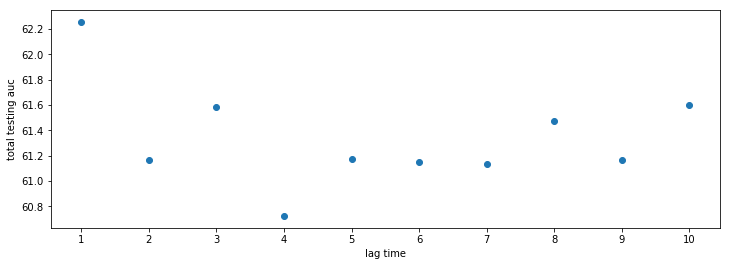

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(lag_time, arr_test_auc)
ax.set_xlabel('lag time')
ax.set_ylabel('total testing auc')
plt.xticks(np.arange(min(lag_time), max(lag_time)+1, 1.0))
plt.show()